In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
from env import host, user, password

## Acquire

In [2]:
# The following functions will be used to acquire all the data from the SQL database 'telco_churn'
# These functions will also be stored in the acquire.py file

def get_connection(db, user=user, host=host, password=password):
    '''
    This function uses my info from my env file to
    create a connection url to access the Codeup db.
    It takes in a string name of a database as an argument.
    '''
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

def new_telco_data():
    '''
    This function reads the telco data from the Codeup db into a df,
    writes it to a csv file, and returns the df.
    '''

    # Create SQL query.
    sql_query = """
           SELECT c.gender, 
                c.senior_citizen,
                c.partner,
                c.dependents,
                c.tenure,
                c.phone_service,
                c.multiple_lines,
                c.online_security,
                c.device_protection,
                c.tech_support,
                c.streaming_tv,
                c.streaming_movies,
                c.paperless_billing,
                c.monthly_charges,
                c.total_charges,
                c.churn,
                ct.contract_type,
                i.internet_service_type,
                p.payment_type
FROM customers as c
JOIN contract_types as ct USING (contract_type_id)
JOIN internet_service_types as i USING (internet_service_type_id)
JOIN payment_types as p USING (payment_type_id);
                """
    
    # Read in DataFrame from Codeup db.
    df = pd.read_sql(sql_query, get_connection('telco_churn'))
    
    return df

def get_telco_data():
    '''
    This function reads in telco data from Codeup database, writes data to
    a csv file if a local file does not exist, and returns a df.
    '''
    if os.path.isfile('telco_df.csv'):
        
        # If csv file exists, read in data from csv file.
        df = pd.read_csv('telco_df.csv', index_col=0)
        
    else:
        
        # Read fresh data from db into a DataFrame.
        df = new_telco_data()
        
        # Write DataFrame to a csv file.
        df.to_csv('telco_df.csv')
        
    return df

df = get_telco_data()
df.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,Female,0,Yes,Yes,65,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,90.45,5957.9,No,Two year,DSL,Mailed check
1,Male,0,No,No,54,No,No phone service,Yes,No,Yes,Yes,No,No,45.20,2460.55,No,Two year,DSL,Credit card (automatic)
2,Female,0,No,No,56,No,No phone service,Yes,Yes,Yes,No,No,No,45.05,2560.1,No,Two year,DSL,Bank transfer (automatic)
3,Male,0,Yes,Yes,20,No,No phone service,Yes,Yes,Yes,No,No,Yes,39.40,825.4,No,Two year,DSL,Credit card (automatic)
4,Male,0,Yes,No,72,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,85.15,6316.2,No,Two year,DSL,Bank transfer (automatic)


## Prepare

Summarize:

In [3]:
df.shape

(7043, 19)

In [4]:
df.describe()

,senior_citizen,tenure,monthly_charges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [5]:
df.isnull().sum()

gender                   0
senior_citizen           0
partner                  0
dependents               0
tenure                   0
phone_service            0
multiple_lines           0
online_security          0
device_protection        0
tech_support             0
streaming_tv             0
streaming_movies         0
paperless_billing        0
monthly_charges          0
total_charges            0
churn                    0
contract_type            0
internet_service_type    0
payment_type             0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   gender                 7043 non-null   object 
 1   senior_citizen         7043 non-null   int64  
 2   partner                7043 non-null   object 
 3   dependents             7043 non-null   object 
 4   tenure                 7043 non-null   int64  
 5   phone_service          7043 non-null   object 
 6   multiple_lines         7043 non-null   object 
 7   online_security        7043 non-null   object 
 8   device_protection      7043 non-null   object 
 9   tech_support           7043 non-null   object 
 10  streaming_tv           7043 non-null   object 
 11  streaming_movies       7043 non-null   object 
 12  paperless_billing      7043 non-null   object 
 13  monthly_charges        7043 non-null   float64
 14  total_charges          7043 non-null   object 
 15  chur

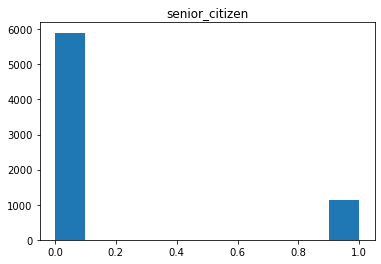

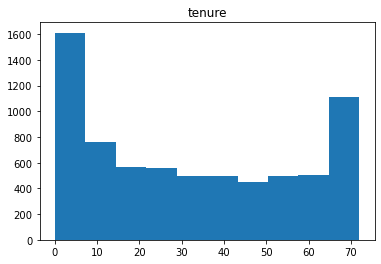

In [7]:
num_cols = df.columns[[df[col].dtype == 'int64' for col in df.columns]]
for col in num_cols:
    plt.hist(df[col])
    plt.title(col)
    plt.show()

In [8]:
ddf = df[df.columns[~df.columns.isin(['monthly_charges','total_charges'])]]

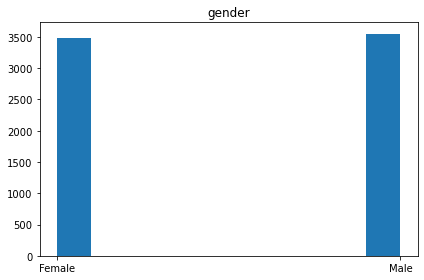

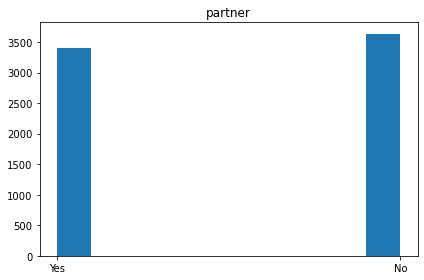

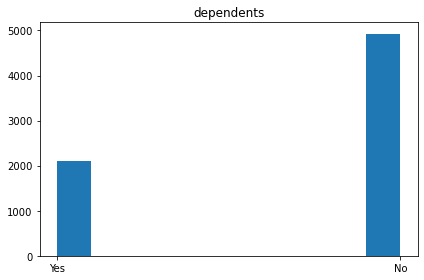

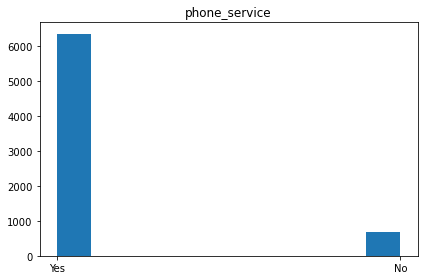

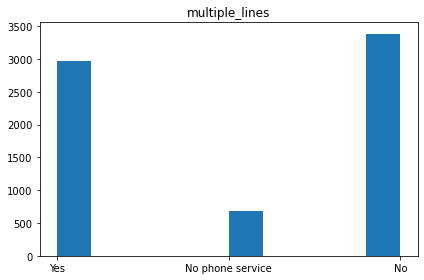

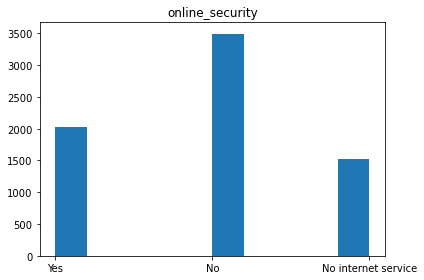

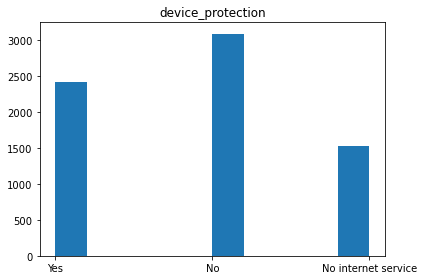

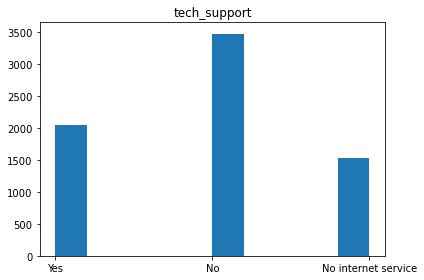

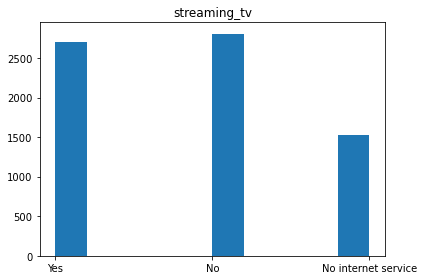

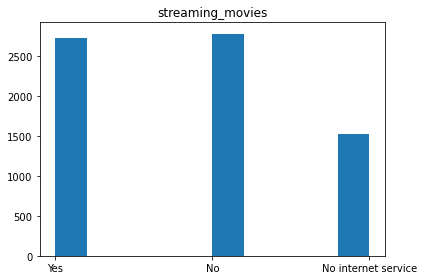

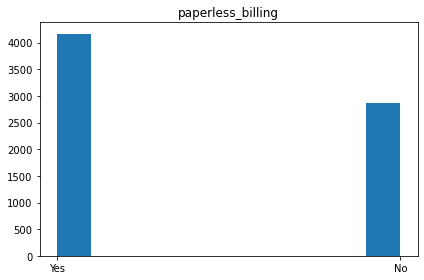

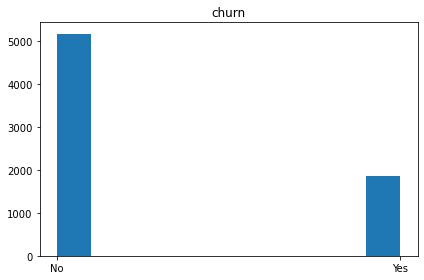

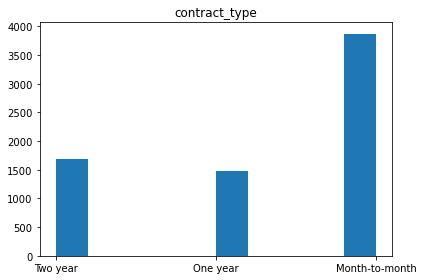

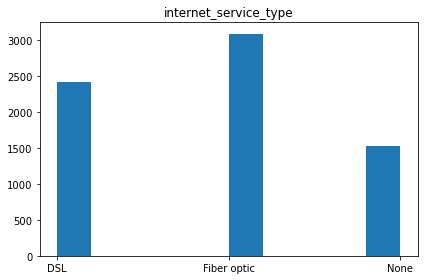

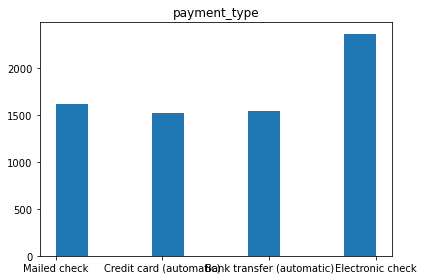

In [9]:
num_cols = ddf.columns[[ddf[col].dtype == 'O' for col in ddf.columns]]
for col in num_cols:
    plt.hist(ddf[col])
    plt.title(col)
    plt.tight_layout()
    plt.show()

In [10]:
obj_cols = df.columns[[df[col].dtype == 'O' for col in df.columns]]
for col in obj_cols:
    print(df[col].value_counts())
    print(df[col].value_counts(normalize=True, dropna=False))
    print('----------------------')

Male      3555
Female    3488
Name: gender, dtype: int64
Male      0.504756
Female    0.495244
Name: gender, dtype: float64
----------------------
No     3641
Yes    3402
Name: partner, dtype: int64
No     0.516967
Yes    0.483033
Name: partner, dtype: float64
----------------------
No     4933
Yes    2110
Name: dependents, dtype: int64
No     0.700412
Yes    0.299588
Name: dependents, dtype: float64
----------------------
Yes    6361
No      682
Name: phone_service, dtype: int64
Yes    0.903166
No     0.096834
Name: phone_service, dtype: float64
----------------------
No                  3390
Yes                 2971
No phone service     682
Name: multiple_lines, dtype: int64
No                  0.481329
Yes                 0.421837
No phone service    0.096834
Name: multiple_lines, dtype: float64
----------------------
No                     3498
Yes                    2019
No internet service    1526
Name: online_security, dtype: int64
No                     0.496663
Yes            

In [11]:
print(df.monthly_charges.sort_values())
print('------------')
print(df.tenure.sort_values())
print('------------')
print(df.total_charges.sort_values())

6405     18.25
6142     18.40
5567     18.55
5555     18.70
6149     18.70
         ...  
3294    118.35
3171    118.60
2666    118.60
2806    118.65
2740    118.75
Name: monthly_charges, Length: 7043, dtype: float64
------------
6257     0
6007     0
236      0
5798     0
5727     0
        ..
2439    72
2440    72
2444    72
3221    72
5862    72
Name: tenure, Length: 7043, dtype: int64
------------
156           
85            
6007          
255           
6257          
         ...  
6455    997.75
6375     998.1
4670    999.45
4360     999.8
5317     999.9
Name: total_charges, Length: 7043, dtype: object


**Immediate takeaways**
- total_charges needs to be converted to a float type
    - some customers haven't been charged at all, must impute value
- a few columns need to be encoded (gender, payment_type, etc.)

Clean:

In [ ]:
# Tidy: total_charges replace non-numeric values with str '0'
df.total_charges = df.total_charges.str.replace(' ','0')
# casts total_charges dtype to float
df.total_charges = df.total_charges.astype(float)
# Tidy: drop duplicate rows
df = df.loc[:,~df.columns.duplicated()]

In [ ]:
dummy_df = pd.get_dummies(df[['gender','embark_town','gender','embark_town','gender','embark_town','gender','embark_town',]], dummy_na=False, drop_first=[True, True])
dummy_df.head()

In [24]:
# convert ['Yes','No'] outcomes to binary
df = df.replace({'paperless_billing': {'Yes': 1, 'No': 0}})
df = df.replace({'partner': {'Yes': 1, 'No': 0}})
df = df.replace({'dependents': {'Yes': 1, 'No': 0}})
df = df.replace({'phone_service': {'Yes': 1, 'No': 0}})

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,Female,0,1,1,65,1,Yes,Yes,Yes,Yes,Yes,Yes,1,90.45,5957.90,No,Two year,DSL,Mailed check
1,Male,0,0,0,54,0,No phone service,Yes,No,Yes,Yes,No,0,45.20,2460.55,No,Two year,DSL,Credit card (automatic)
2,Female,0,0,0,56,0,No phone service,Yes,Yes,Yes,No,No,0,45.05,2560.10,No,Two year,DSL,Bank transfer (automatic)
3,Male,0,1,1,20,0,No phone service,Yes,Yes,Yes,No,No,1,39.40,825.40,No,Two year,DSL,Credit card (automatic)
4,Male,0,1,0,72,1,Yes,No,Yes,Yes,Yes,Yes,1,85.15,6316.20,No,Two year,DSL,Bank transfer (automatic)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Female,0,1,1,1,1,No,No internet service,No internet service,No internet service,No internet service,No internet service,0,20.05,20.05,No,Month-to-month,None,Mailed check
7039,Female,0,0,0,19,1,No,No internet service,No internet service,No internet service,No internet service,No internet service,0,19.90,367.55,No,Month-to-month,None,Mailed check
7040,Female,0,0,0,6,1,No,No internet service,No internet service,No internet service,No internet service,No internet service,0,19.70,129.55,No,Month-to-month,None,Credit card (automatic)
7041,Male,0,0,0,1,1,No,No internet service,No internet service,No internet service,No internet service,No internet service,0,18.90,18.90,No,Month-to-month,None,Mailed check


In [18]:
df.sample(5)

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
1257,Female,1,No,No,1,No,No phone service,No,No,No,No,No,No,25.25,25.25,Yes,Month-to-month,DSL,Electronic check
4595,Female,0,Yes,No,21,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,103.90,2254.20,Yes,Month-to-month,Fiber optic,Electronic check
3276,Female,1,Yes,No,42,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,105.20,4599.15,No,One year,Fiber optic,Bank transfer (automatic)
6916,Male,0,No,No,12,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No,20.05,265.45,No,Month-to-month,None,Credit card (automatic)
5205,Female,1,No,No,64,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,108.95,7111.30,No,Month-to-month,Fiber optic,Bank transfer (automatic)


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   gender                 7043 non-null   object 
 1   senior_citizen         7043 non-null   int64  
 2   partner                7043 non-null   object 
 3   dependents             7043 non-null   object 
 4   tenure                 7043 non-null   int64  
 5   phone_service          7043 non-null   object 
 6   multiple_lines         7043 non-null   object 
 7   online_security        7043 non-null   object 
 8   device_protection      7043 non-null   object 
 9   tech_support           7043 non-null   object 
 10  streaming_tv           7043 non-null   object 
 11  streaming_movies       7043 non-null   object 
 12  paperless_billing      7043 non-null   object 
 13  monthly_charges        7043 non-null   float64
 14  total_charges          7043 non-null   float64
 15  chur

In [15]:
obj_cols = df.columns[[df[col].dtype == 'O' for col in df.columns]]
for col in obj_cols:
    print(df[col].value_counts())
    print(df[col].value_counts(normalize=True, dropna=False))
    print('----------------------')

Male      3555
Female    3488
Name: gender, dtype: int64
Male      0.504756
Female    0.495244
Name: gender, dtype: float64
----------------------
No     3641
Yes    3402
Name: partner, dtype: int64
No     0.516967
Yes    0.483033
Name: partner, dtype: float64
----------------------
No     4933
Yes    2110
Name: dependents, dtype: int64
No     0.700412
Yes    0.299588
Name: dependents, dtype: float64
----------------------
Yes    6361
No      682
Name: phone_service, dtype: int64
Yes    0.903166
No     0.096834
Name: phone_service, dtype: float64
----------------------
No                  3390
Yes                 2971
No phone service     682
Name: multiple_lines, dtype: int64
No                  0.481329
Yes                 0.421837
No phone service    0.096834
Name: multiple_lines, dtype: float64
----------------------
No                     3498
Yes                    2019
No internet service    1526
Name: online_security, dtype: int64
No                     0.496663
Yes            